# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [5]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 200
# percentage of training set to use as validation
valid_size = 0.2 # This means the training data will be 80%

image_net_resized_size = 224

IMG_MEAN = torch.tensor( [0.485, 0.456, 0.406])
IMG_STD = torch.tensor([0.229, 0.224, 0.225])

normalize = transforms.Normalize(mean=IMG_MEAN,
                             std=IMG_STD)

train_transform = transforms.Compose([transforms.RandomRotation(30), # Resize input image
                                 transforms.RandomResizedCrop(image_net_resized_size),# Crop input image. 224 is the desired output size after the crop
                                transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                      normalize])

test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(image_net_resized_size),
                                     transforms.ToTensor(),
                                     normalize])

train_dataset = datasets.ImageFolder('landmark_images/train', transform=train_transform)
test_dataset = datasets.ImageFolder('landmark_images/test', transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print('Num Training Data:{}, num validation data:{}, num test data:{}'.format(len(train_idx), len(valid_idx), len(test_dataset)))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


Num Training Data:3997, num validation data:999, num test data:1250


In [6]:
idx_to_class_dict = {idx : class_name.split('.')[1] for idx, class_name in enumerate(train_dataset.classes)}
print(idx_to_class_dict)

{0: 'Haleakala_National_Park', 1: 'Mount_Rainier_National_Park', 2: 'Ljubljana_Castle', 3: 'Dead_Sea', 4: 'Wroclaws_Dwarves', 5: 'London_Olympic_Stadium', 6: 'Niagara_Falls', 7: 'Stonehenge', 8: 'Grand_Canyon', 9: 'Golden_Gate_Bridge', 10: 'Edinburgh_Castle', 11: 'Mount_Rushmore_National_Memorial', 12: 'Kantanagar_Temple', 13: 'Yellowstone_National_Park', 14: 'Terminal_Tower', 15: 'Central_Park', 16: 'Eiffel_Tower', 17: 'Changdeokgung', 18: 'Delicate_Arch', 19: 'Vienna_City_Hall', 20: 'Matterhorn', 21: 'Taj_Mahal', 22: 'Moscow_Raceway', 23: 'Externsteine', 24: 'Soreq_Cave', 25: 'Banff_National_Park', 26: 'Pont_du_Gard', 27: 'Seattle_Japanese_Garden', 28: 'Sydney_Harbour_Bridge', 29: 'Petronas_Towers', 30: 'Brooklyn_Bridge', 31: 'Washington_Monument', 32: 'Hanging_Temple', 33: 'Sydney_Opera_House', 34: 'Great_Barrier_Reef', 35: 'Monumento_a_la_Revolucion', 36: 'Badlands_National_Park', 37: 'Atomium', 38: 'Forth_Bridge', 39: 'Gateway_of_India', 40: 'Stockholm_City_Hall', 41: 'Machu_Picch

In [7]:
classes_number_of_images = [0 for i in range(len(idx_to_class_dict))]
for _, labels in train_loader:
    for a_label in labels:
        classes_number_of_images[a_label] += 1
print(classes_number_of_images)

[72, 79, 75, 76, 78, 78, 79, 84, 80, 80, 80, 81, 76, 81, 81, 75, 84, 81, 78, 77, 83, 82, 70, 85, 91, 85, 86, 85, 78, 77, 76, 81, 76, 85, 77, 88, 75, 80, 85, 76, 84, 75, 75, 77, 83, 83, 82, 84, 84, 74]


In [8]:
def anti_image_processing(image_tensor: torch.Tensor):
    for i in range(3):
        image_tensor[i,:,:] = image_tensor[i,:,:] * IMG_STD[i] + IMG_MEAN[i]
    return image_tensor.numpy().transpose(1, 2, 0)

def normalize_numpy_image_to_tensor(np_image):
    image = torch.from_numpy(np_image).type(torch.FloatTensor) # shape (224, 224, 3)
    for i in range(3):
        image[:,:,i] = image[:,:,i] / IMG_STD - IMG_MEAN
    image = image.view(1, 3, 224, 224)
    return image


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:
Train/validation:
- The train dataset was split into test/val dataset with the ratio 80% and 20% respectively
- A sampler was used in both to split the data with the mentioned ratios randomly

A batch size of 200 images was chosen to be fed to the dataloader

The dataset was augmented using:
- Random rotation
- Random resized crop
- Random horizontal flip with 50% probability

The mean and standard deviation were computed to normalize the input images



### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

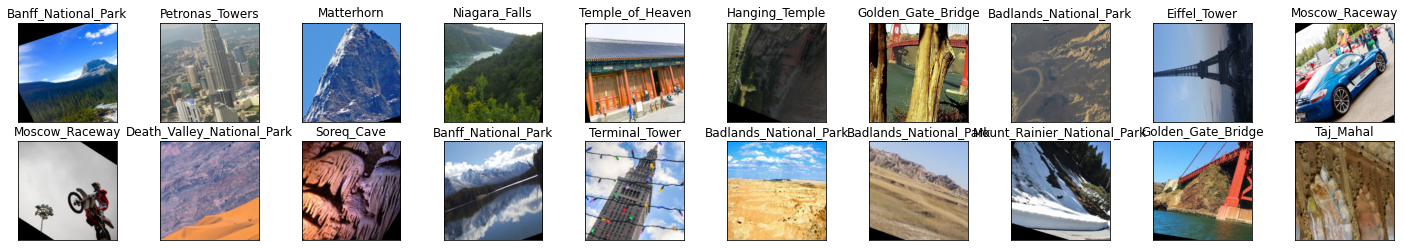

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

dataiter = iter(train_loader)

images, labels = (dataiter.next())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(anti_image_processing(images[idx])))
    ax.set_title("{}".format(str(idx_to_class_dict[labels[idx].item()])))



### Initialize use_cuda variable

In [10]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
device = 'gpu' if use_cuda else 'cpu'

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [11]:
## TODO: select loss functiondq
criterion_scratch = torch.nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    return torch.optim.Adam(model.parameters(), lr=1e-3)

    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(25088, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 256)
        self.fc4 = nn.Linear(256, 50)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))# 224x224x16
        x = self.maxpool(x)# 112x112x16
        x = F.relu(self.conv2(x))# 112x112x64
        x = self.maxpool(x)# 56x56x65
        x = F.relu(self.conv3(x))# 56x56x128
        x = self.maxpool(x)# 28x28x128
        x = F.relu(self.conv4(x))# 28x28x256
        x = self.maxpool(x)# 14x14x256
        x = F.relu(self.conv5(x))# 14x14x512
        x = self.maxpool(x)# 7x7x512
        x = x.view(x.shape[0], -1)# batch_size, 7*7*512
        x = self.dropout(F.relu(self.fc1(x))) # 2048
        x = self.dropout(F.relu(self.fc2(x))) # 1024
        x = self.dropout(F.relu(self.fc3(x))) # 256
        x = self.fc4(x) # 50 -> there is no activation function, because cross entropy is used as the criterion
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [13]:
model_scratch

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=50, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__
The problem is to classify images into 50 categories. That's why using CNNs is crucial.
A combination of CNN layers, max pooling were used to decrease the size of the image, while increasing the depth of the features extracted by the model.
At the end a bunch of linear layers with ReLU activation functions were used after flattening the features from CNN feature extraction part.
The final lienar fully connected layer must have 50 neurons, as we try to classify 50 classes.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [14]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_losses, valid_losses = [], []
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        accuracy = 0.0

        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            model_output = model(data)
            loss = criterion(model_output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        ######################
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            model_output = model(data)
            loss = criterion(model_output, target)
            valid_loss += loss.item()
            top_predictions, top_classes = model_output.topk(1, dim=1)
            equals = top_classes == target.view(top_classes.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

        # print training/validation statistics
        train_loss /= len(loaders['train'])
        valid_loss /= len(loaders['valid'])
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        accuracy = accuracy / len(loaders['valid']) * 100
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {}'.format(
            epoch, 
            train_loss,
            valid_loss,
            accuracy
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model, train_losses, valid_losses

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [8]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    # for every Linear and conv layers in a model.
    classname = m.__class__.__name__
    if classname.find('Linear') != -1 or classname.find('Conv') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0) # The first number is the start of the range and the second is the end of the range
				#m.weight.data.uniform_(0, 1/np.sqrt(m.in_features)) # The first number is the mean and the second is the standard deviation # The best way to initialize weights
        m.bias.data.fill_(0)
    
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch, train_losses, valid_losses = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

Epoch: 1 	Training Loss: 34652797044189810688.000000 	Validation Loss: 3.912115 	Accuracy: 1.3000001907348633
Validation loss decreased (inf --> 3.912115).  Saving model ...
Epoch: 2 	Training Loss: 3.912060 	Validation Loss: 3.912215 	Accuracy: 1.3000001907348633
Epoch: 3 	Training Loss: 3.912035 	Validation Loss: 3.912315 	Accuracy: 1.3000001907348633
Epoch: 4 	Training Loss: 3.912012 	Validation Loss: 3.912413 	Accuracy: 1.3000001907348633
Epoch: 5 	Training Loss: 3.911986 	Validation Loss: 3.912512 	Accuracy: 1.3105264902114868
Epoch: 6 	Training Loss: 3.911963 	Validation Loss: 3.912609 	Accuracy: 1.3000001907348633
Epoch: 7 	Training Loss: 3.911940 	Validation Loss: 3.912706 	Accuracy: 1.3000001907348633
Epoch: 8 	Training Loss: 3.911920 	Validation Loss: 3.912799 	Accuracy: 1.3000000715255737
Epoch: 9 	Training Loss: 3.911899 	Validation Loss: 3.912892 	Accuracy: 1.3000001907348633
Epoch: 10 	Training Loss: 3.911878 	Validation Loss: 3.912986 	Accuracy: 1.3105263710021973
Epoch:

KeyboardInterrupt: 

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [ ]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
# train the model
model_scratch, train_losses, valid_losses = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'model_scratch.pt')

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

Epoch: 1 	Training Loss: 3.916042 	Validation Loss: 3.913836 	Accuracy: 1.8318541049957275
Validation loss decreased (inf --> 3.913836).  Saving model ...
Epoch: 2 	Training Loss: 3.904390 	Validation Loss: 3.899224 	Accuracy: 2.029093027114868
Validation loss decreased (3.913836 --> 3.899224).  Saving model ...


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [15]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 50
# percentage of training set to use as validation
valid_size = 0.2 # This means the training data will be 80%

image_net_resized_size = 224

IMG_MEAN = torch.tensor( [0.485, 0.456, 0.406])
IMG_STD = torch.tensor([0.229, 0.224, 0.225])

normalize = transforms.Normalize(mean=IMG_MEAN,
                             std=IMG_STD)

train_transform = transforms.Compose([transforms.RandomRotation(30), # Resize input image
                                 transforms.RandomResizedCrop(image_net_resized_size),# Crop input image. 224 is the desired output size after the crop
                                transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                      normalize])

test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(image_net_resized_size),
                                     transforms.ToTensor(),
                                     normalize])

train_dataset = datasets.ImageFolder('landmark_images/train', transform=train_transform)
test_dataset = datasets.ImageFolder('landmark_images/test', transform=test_transform)

# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

print('Num Training Data:{}, num validation data:{}, num test data:{}'.format(len(train_idx), len(valid_idx), len(test_dataset)))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)


loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


Num Training Data:3997, num validation data:999, num test data:1250


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [16]:
## TODO: select loss function
criterion_transfer = torch.nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
    return optimizer
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
## TODO: Specify model architecture
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

vgg19_model = models.vgg19(pretrained=True)
# Freeze parameters so we don't backprop through them
for param in vgg19_model.features.parameters():
    param.requires_grad = False

#model.classifier[6].out_features = 50
classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 50)
)

vgg19_model.classifier = classifier

model_transfer = vgg19_model

print(model_transfer)
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__

VGG was trained on imageNet competition that has 1000 output classes. That's why its feature extraction part is concrete and can easily be adapted to our problem.
Furthermore, the model was trained on millions of images, while our dataset contains a few thousands of images, it will help boost the learning process of our algorithm.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [15]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
model_transfer, transfer_train_losses, transfer_valid_losses = train(100, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer.classifier),
                      criterion_transfer, use_cuda, 'model_transfer.pt')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(transfer_train_losses, label='Training loss')
plt.plot(transfer_valid_losses, label='Validation loss')
plt.legend(frameon=False)


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 4.871405 	Validation Loss: 3.125688 	Accuracy: 14.704081535339355
Validation loss decreased (inf --> 3.125688).  Saving model ...
Epoch: 2 	Training Loss: 3.150967 	Validation Loss: 2.782634 	Accuracy: 25.62856674194336
Validation loss decreased (3.125688 --> 2.782634).  Saving model ...
Epoch: 3 	Training Loss: 2.903151 	Validation Loss: 2.577736 	Accuracy: 31.026533126831055
Validation loss decreased (2.782634 --> 2.577736).  Saving model ...
Epoch: 4 	Training Loss: 2.803322 	Validation Loss: 2.485936 	Accuracy: 30.83469581604004
Validation loss decreased (2.577736 --> 2.485936).  Saving model ...
Epoch: 5 	Training Loss: 2.656674 	Validation Loss: 2.431967 	Accuracy: 33.43061065673828
Validation loss decreased (2.485936 --> 2.431967).  Saving model ...
Epoch: 6 	Training Loss: 2.648437 	Validation Loss: 2.380276 	Accuracy: 33.228580474853516
Validation loss decreased (2.431967 --> 2.380276).  Saving model ...
Epoch: 7 	Training Loss: 2.593231 	Validation Lo

KeyboardInterrupt: 

In [18]:
# In case you do not want to run the above cell again (The model is already trained)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [19]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

NameError: name 'test' is not defined

---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

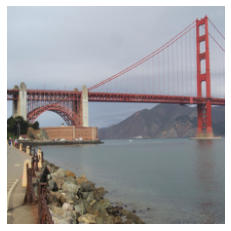

classes: ['Petronas_Towers', 'London_Olympic_Stadium', 'Brooklyn_Bridge', 'Sydney_Harbour_Bridge', 'Sydney_Opera_House'], predictions: [[22.416128 19.845165 18.499138 18.042555 15.358702]]


In [36]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image = np.array(Image.open(img_path).resize((224, 224)))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    image = torch.from_numpy(image).type(torch.FloatTensor) # shape (224, 224, 3)
    image = image.view(1, 3, 224, 224)
    if use_cuda:
        image = image.cuda()
    #print(image.shape)
    model_output = model_transfer(image)
    top_predictions, top_classes = model_output.topk(k, dim=1)
    top_classes = top_classes.detach().cpu().numpy().squeeze()
    top_classes_names = [idx_to_class_dict[class_id] for class_id in top_classes]
    return top_classes_names, top_predictions.detach().cpu().numpy()


# test on a sample image
classes, predictions = predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)
print('classes: {}, predictions: {}'.format(classes, predictions))

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

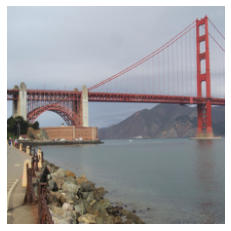

Is this a picture of: Taj_Mahal, Gateway_of_India,  or  Monumento_a_la_Revolucion


In [37]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks, _ = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    print('Is this a picture of:', end=' ')
    for i in range(len(predicted_landmarks) - 1):
        print(predicted_landmarks[i], end=', ')
    print(' or ', predicted_landmarks[len(predicted_landmarks) - 1])

    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
- Use bigger (more complex) network
- Compare between more networks to achieve better performance
- Augment the dataset with another available datasets to increase performance
- Try more hyper parameters, like loss functions, optimizers, learning rates
- Use learning rate scheduler
- Train for more epochs

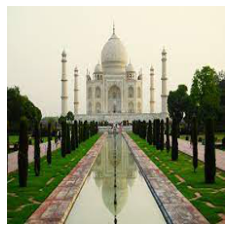

Is this a picture of: London_Olympic_Stadium, Sydney_Opera_House,  or  Petronas_Towers


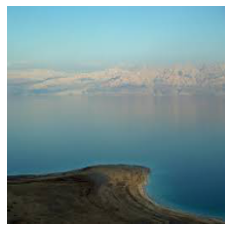

Is this a picture of: London_Olympic_Stadium, Sydney_Opera_House,  or  Brooklyn_Bridge


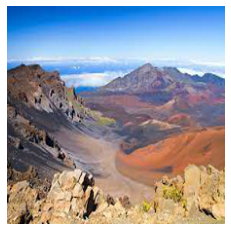

Is this a picture of: London_Olympic_Stadium, Petronas_Towers,  or  Brooklyn_Bridge


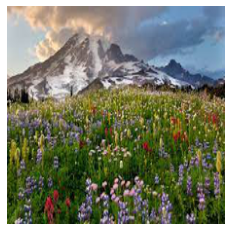

Is this a picture of: London_Olympic_Stadium, Sydney_Opera_House,  or  Moscow_Raceway


In [38]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
import glob

for image_path in glob.glob('./local_test_images/*.jpeg'):
    suggest_locations(image_path)